In [1]:
# Core libraries
import re,sys, os

# image processing
import cv2
import numpy as np
from utils.imutils import jimshow
from utils.imutils import jimshow_channel
import matplotlib.pyplot as plt

# OCR tool
import pytesseract

# NLP
import wordsegment
from autocorrect import Speller

## Simple OCR

In [2]:
filename = "data/img/jefferson.jpg"

__Vanilla tesseract__

In [3]:
text = pytesseract.image_to_string(filename)

In [4]:
print(text)

3 CREATOR ¥

BIGHT. AMONG ; THESE AREL

ANE THE PURSUIT oe eek THAT

"SOLEMNLY eee AND DE SARE, THAT _

D Pik — OF THIS
DECLARATI ON, WITH A se RELIANCE

PROVIDENCE, WE U’
OUR LIVES, OUR FORTUNES AND OUR

 



In [5]:
text = pytesseract.image_to_data(filename, output_type='data.frame')
text

,level,page_num,block_num,par_num,line_num,word_num,left,top,width,height,conf,text
0,1,1,0,0,0,0,0,0,4320,3240,-1,NaN
1,2,1,1,0,0,0,1511,1157,379,105,-1,NaN
2,3,1,1,1,0,0,1511,1157,379,105,-1,NaN
3,4,1,1,1,1,0,1511,1157,379,105,-1,NaN
4,5,1,1,1,1,1,1511,1171,2,5,38,3
...,...,...,...,...,...,...,...,...,...,...,...,...
61,5,1,6,1,2,6,2674,2548,170,86,63,OUR
62,2,1,7,0,0,0,0,0,4320,3240,-1,NaN
63,3,1,7,1,0,0,0,0,4320,3240,-1,NaN
64,4,1,7,1,1,0,0,0,4320,3240,-1,NaN


## Use open-cv

In [6]:
image = cv2.imread(filename)

__Crop__

In [7]:
(cX, cY) = (image.shape[1]//2, image.shape[0]//2)
cropped = image[cY-750:cY+1150, cX-750:cX+700]

__Greyscale__

In [8]:
grey = cv2.cvtColor(cropped, cv2.COLOR_BGR2GRAY)

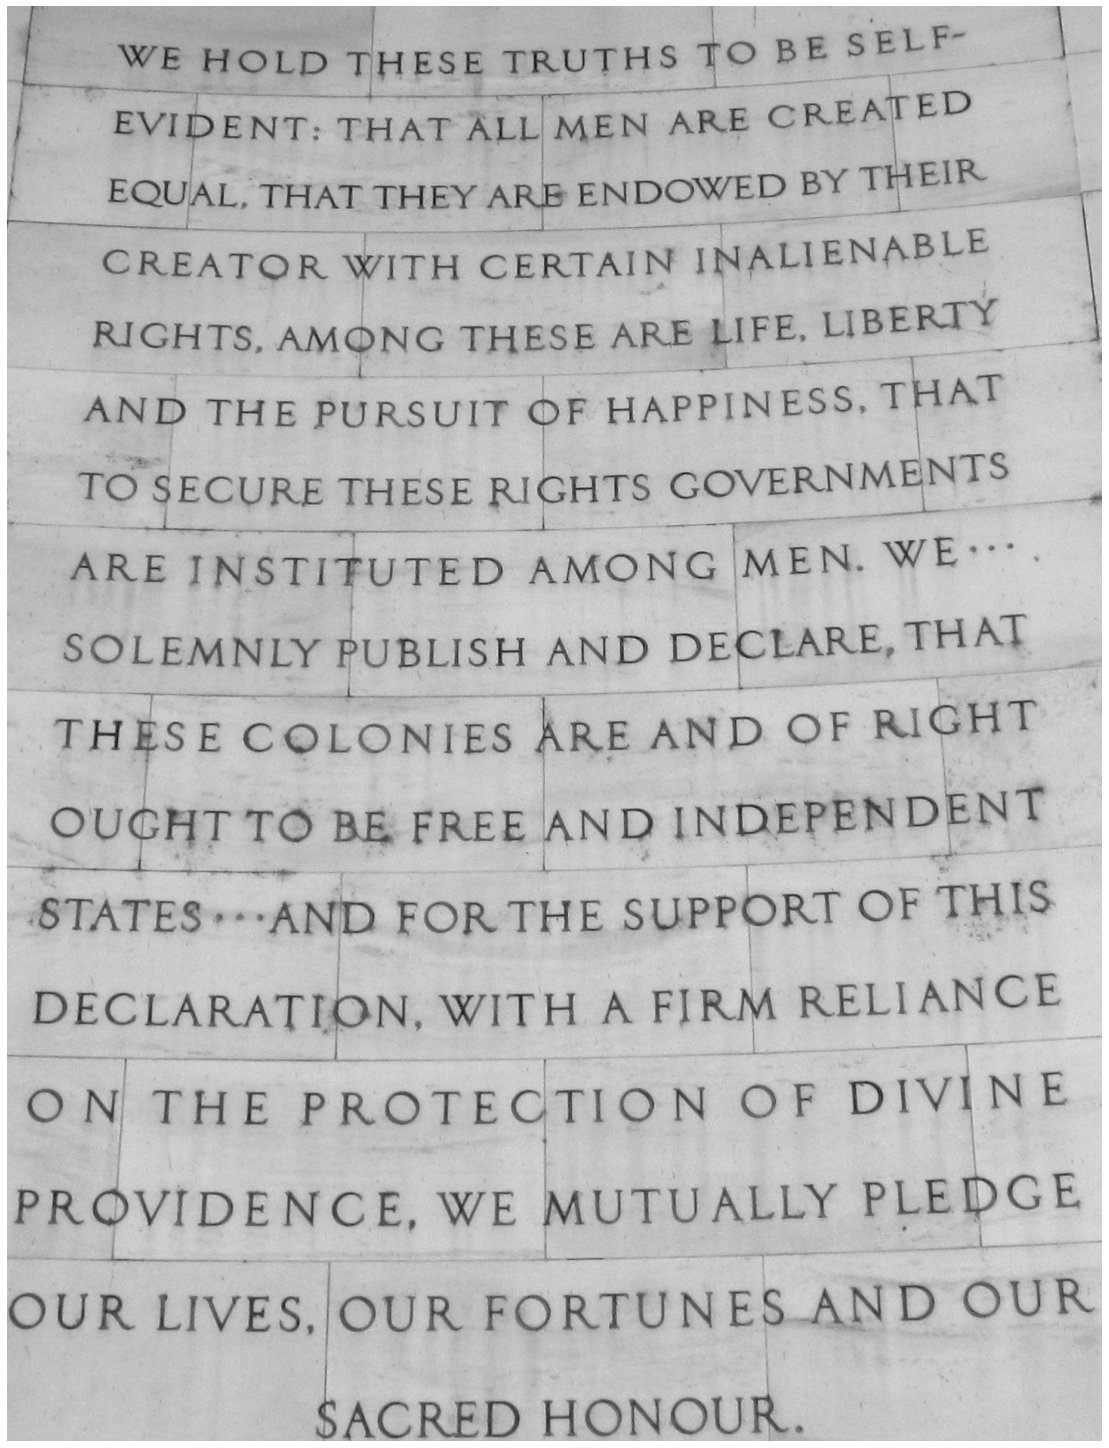

In [9]:
jimshow_channel(grey)

__OCR__

In [10]:
text = pytesseract.image_to_string(grey)

In [11]:
print(text)

ee tt

STATES

WE WE HOLD THESE 7 meyyys To BE SELF
EVIDENT: THAT ALL MEN ‘ARE CREATED
EIR

EQUAL, THAT THEY -ARB El ENDOWED BY TH :
CREATOR WITH CERTAIN INALIENABLE |

RIGHTS, AMONG THESE ARE LIFE. | LIBERTY
AND THE PURSUIT OF HAPPINESS: THAT

TO SECURE THESE RIGHTS GOVERNMENTS
ARE E INSTITUTED | AMONG |MEN. WE:
SOLEMNLY PUBLISH AND DECLARE, THAT
THESE COLONIES ARE. AND OF RIGHT
OUGHT TO BE FREE AND INDEPEN DENT
TES AND FOR THE SUPPORT OF THIS
DECLARATION, WITH A FIRM RELIANCE
O N THE ‘PROTECTION OF DIVINE
PROVIDE NCE, WE MUTUALLY PLEDGE

OUR LIVES, OUR FORTUNES.AND OUR
bACRED HONOUR.



__Thresholding__

In [12]:
# threshold
(T, thres) = cv2.threshold(grey, 110, 255, cv2.THRESH_BINARY)

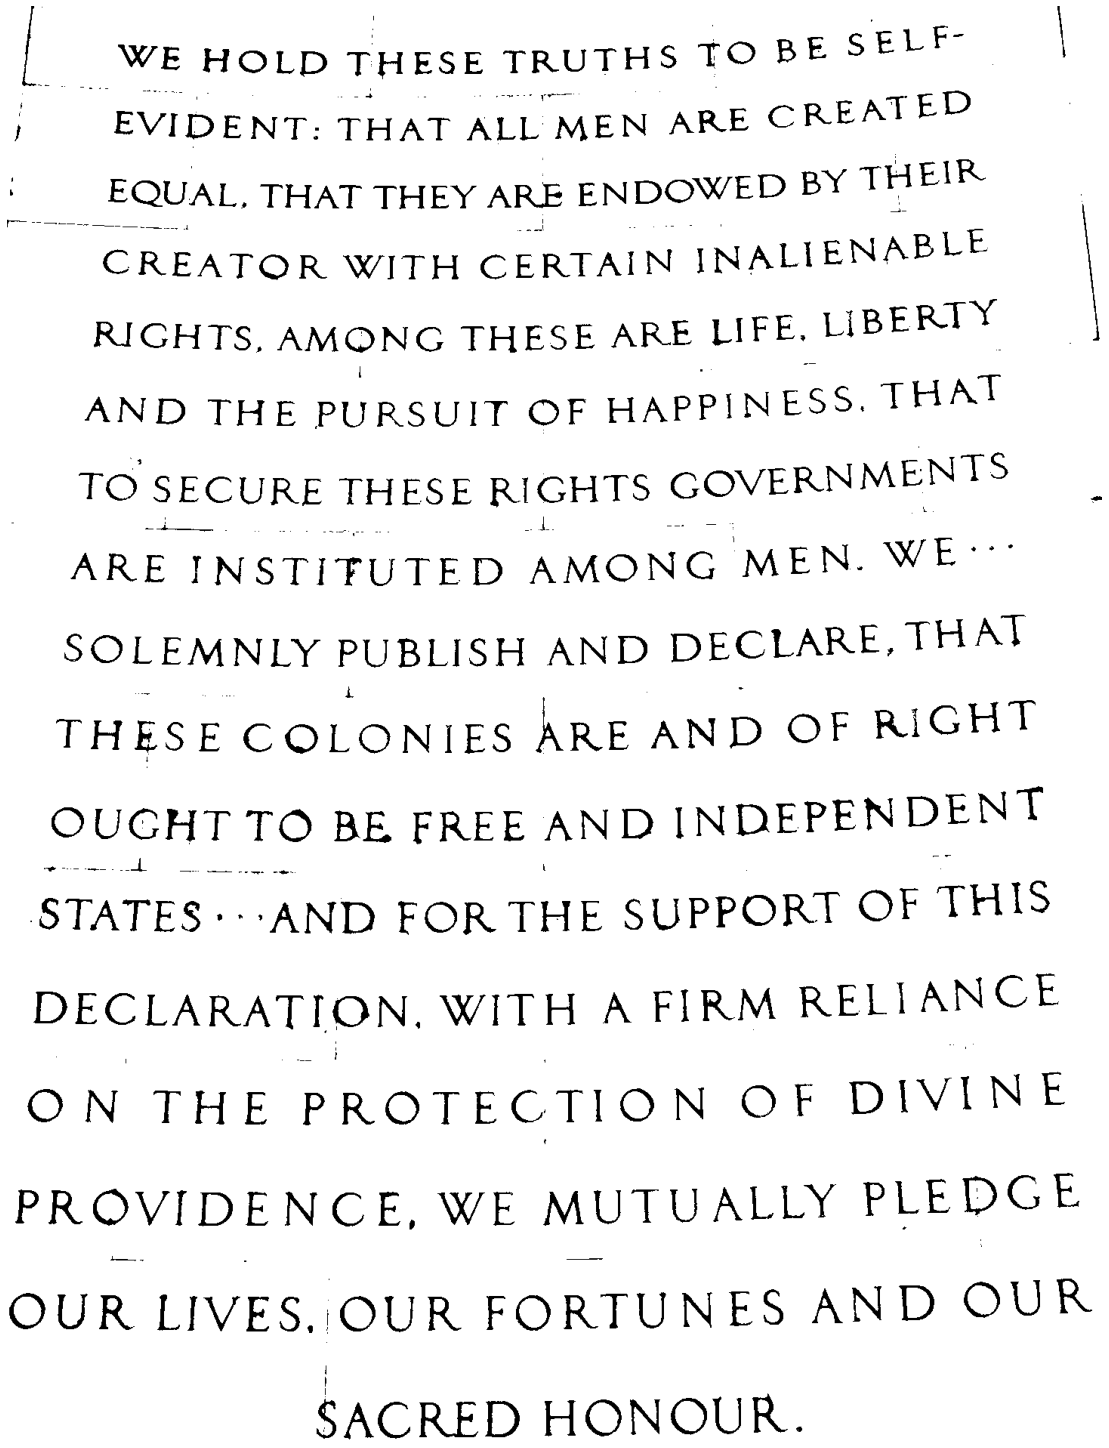

In [13]:
jimshow_channel(thres)

__OCR__

In [14]:
text = pytesseract.image_to_string(thres)

In [15]:
print(text)

!

__ WE HOLD THESE TRUTHS TO BE SELF
EVIDENT: THAT ALL MEN ARE CREATED
- EQUAL. THAT THEY ARE ENDOWED BY THEIR
CREATOR WITH CERTAIN INALIENABLE |
RIGHTS, AMONG THESE ARE LIFE. LIBERTY
AND THE PURSUIT OF HAPPINESS. THAT
TO SECURE THESE RI IGHTS GOVERNMENT
ARE INSTIFUTED AMONG MEN. WE-""
SOLEMNLY PUBLISH AND DECLARE THAT
THESE COLONIES ARE AND OF RIGHT
OUGHT TO BE FREE AND INDEPENDENT
STATES AND FOR THE SUPPORT OF THIS
DECLARATION. WITH A FIRM RELIANCE
ON THE PROTECTION O F DIVINE
PROVIDENCE, WE MUTUALLY PLEDGE
OUR LIVES. OUR FORTUNES AND OUR

SACRED HONOUR.



__Tweak parameters__

In [16]:
custom_oem_psm_config = r'--oem 3 --psm 7'

In [17]:
print(pytesseract.image_to_string(thres))

!

__ WE HOLD THESE TRUTHS TO BE SELF
EVIDENT: THAT ALL MEN ARE CREATED
- EQUAL. THAT THEY ARE ENDOWED BY THEIR
CREATOR WITH CERTAIN INALIENABLE |
RIGHTS, AMONG THESE ARE LIFE. LIBERTY
AND THE PURSUIT OF HAPPINESS. THAT
TO SECURE THESE RI IGHTS GOVERNMENT
ARE INSTIFUTED AMONG MEN. WE-""
SOLEMNLY PUBLISH AND DECLARE THAT
THESE COLONIES ARE AND OF RIGHT
OUGHT TO BE FREE AND INDEPENDENT
STATES AND FOR THE SUPPORT OF THIS
DECLARATION. WITH A FIRM RELIANCE
ON THE PROTECTION O F DIVINE
PROVIDENCE, WE MUTUALLY PLEDGE
OUR LIVES. OUR FORTUNES AND OUR

SACRED HONOUR.



__Manual cleanup__

In [18]:
def replace(string):
    processed = string.replace("\n"," ")\
                     .replace("\n\n"," ")\
                     .replace("__"," ")\
                     .replace(" - "," ")\
                     .replace('-""' ," ")\
                     .replace("|", "")\
                     .replace("!", "")\
                     .replace("\s"," ")\
                     .lstrip()
    return " ".join(processed.split())

__Print manually cleaned text__

In [19]:
text = pytesseract.image_to_string(thres)
print(replace(text))

WE HOLD THESE TRUTHS TO BE SELF EVIDENT: THAT ALL MEN ARE CREATED EQUAL. THAT THEY ARE ENDOWED BY THEIR CREATOR WITH CERTAIN INALIENABLE RIGHTS, AMONG THESE ARE LIFE. LIBERTY AND THE PURSUIT OF HAPPINESS. THAT TO SECURE THESE RI IGHTS GOVERNMENT ARE INSTIFUTED AMONG MEN. WE SOLEMNLY PUBLISH AND DECLARE THAT THESE COLONIES ARE AND OF RIGHT OUGHT TO BE FREE AND INDEPENDENT STATES AND FOR THE SUPPORT OF THIS DECLARATION. WITH A FIRM RELIANCE ON THE PROTECTION O F DIVINE PROVIDENCE, WE MUTUALLY PLEDGE OUR LIVES. OUR FORTUNES AND OUR SACRED HONOUR.


__Simple spell check__

In [20]:
# intitialise autocorrect and wordsegment classes
check = Speller(lang='en')
wordsegment.load()

In [21]:
def ocr_correct(ocr_text):
    # Segment based on unigram and bigram frequency
    ocr = wordsegment.segment(ocr_text)
    # join list as string
    ocr = " ".join(ocr)
    # spellcheck string
    ocr = check(ocr)
    
    return ocr

In [22]:
ocr_correct(text)

'we hold these truths to be self evident that all men are created equal that they are endowed by their creator with certain inalienable rights among these are life liberty and the pursuit of happiness that to secure the semi rights government are inst if used among men we solemnly publish and declare that these colonies are and of right ought to be free and independent states and for the support of this declaration with a firm reliance on the protection of divine providence we mutually pledge our lives our fortunes and our sacred honour'

## Working with memes (or similar)

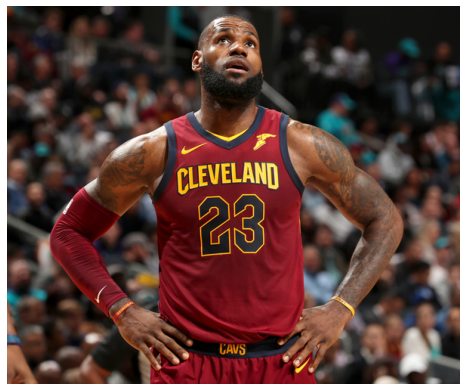

In [23]:
meme = cv2.imread("EAST/images/lebron_james.jpg")
jimshow(meme)

__No processing__

In [24]:
pytesseract.image_to_string(meme)

' \n\x0c'

__Processing using ```open-cv```___

In [25]:
def order_boxes(boxes):
    ''' 
    Method that orders boxes in a left-to-right, top-to-bottom
    approach. This has it's faults when it comes to memes,
    but generally is a safe-approach.
    '''
    boxes.sort(key=lambda b: b[1])
    # initially the line bottom is set to be the bottom of the first rect
    line_bottom = boxes[0][1]+boxes[0][3]-1
    line_begin_idx = 0
    for i in range(len(boxes)):
        # when a new box's top is below current line's bottom
        # it's a new line
        if boxes[i][1] > line_bottom:
            # sort the previous line by their x
            boxes[line_begin_idx:i] = sorted(boxes[line_begin_idx:i], key=lambda b: b[0])
            line_begin_idx = i
        # regardless if it's a new line or not
        # always update the line bottom
        line_bottom = max(boxes[i][1]+boxes[i][3]-1, line_bottom)
    # sort the last line
    boxes[line_begin_idx:] = sorted(boxes[line_begin_idx:], key=lambda b: b[0])
    return boxes

def get_contours(img, inverted=False):
    """
    Find contours in the images corresponding to text.
    
    Then find rectangles which bound this together and OCR these boxes.
    
    NB! Binary thresholding is only useful for this problem space! 
    
    Q: Why? How would you solve this?
    """
    # Invert the image
    if inverted:
        img = cv2.bitwise_not(img)
    # Convert the image to gray scale 
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 

    # Performing binary threshold
    ret, thresh1 = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY_INV) 
    #cv2.imwrite("thresh1.png", thresh1)  
    rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, 
                                            (18, 18)) 

    # Appplying dilation on the threshold image 
    dilation = cv2.dilate(thresh1, rect_kernel, iterations = 1) 
    
    # Finding contours 
    contours, hierarchy = cv2.findContours(dilation, cv2.RETR_EXTERNAL,  
                                                     cv2.CHAIN_APPROX_NONE)
    bounding_rectangles = []
    #Sort rectangles
    for cnt in contours: 
        # for each set of contours, find the rectangle which 'bounds them'
        (x, y, w, h) = cv2.boundingRect(cnt)
        bounding_rectangles.append((x, y, w, h))
    # order these from left-to-right and top-to-bottom
    bounding_rectangles = order_boxes(bounding_rectangles)
    return bounding_rectangles

def extract_text(img):
    """
    Extract text from images with complex backgrounds.
    
    In this case, we have prior knowledge of memes - white text, image background
    """
    # load image
    image = cv2.imread(img) 
    im2 = image.copy() 
    # get bounding rectangles
    bounding_rectangles = get_contours(image)
    #bounding_rectangles += get_contours(image, inverted=True)
    
    # Convert the image to gray scale 
    gray = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY) 
    # Performing OTSU threshold
    ret, thresh1 = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY_INV) 
    
    # print the image to show post-threshold appearance
    jimshow_channel(thresh1)
    # create empty string
    ocr_text = ""
    # find text in each box
    for rect in bounding_rectangles:
        # get dimensions
        (x, y, w, h) = rect
        # Cropping the text block for giving input to OCR 
        cropped = thresh1[y:y + h, x:x + w] 
        # Apply OCR on the cropped image 
        text = pytesseract.image_to_string(cropped)
        # Appending the text into file 
        if len(text) > 1:
            ocr_text += text + "\n"
    return ocr_text

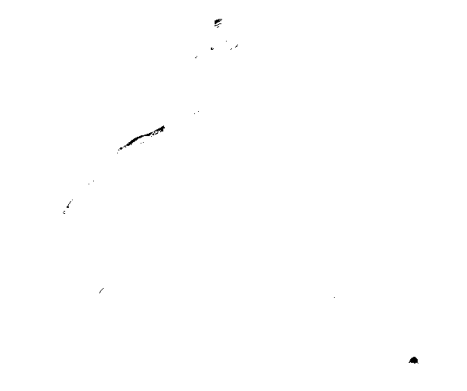

In [26]:
ocr_text = extract_text("EAST/images/lebron_james.jpg")

In [27]:
print(ocr_text)

a


